In [1]:
#%% libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from astropy.coordinates import ICRS, AltAz, EarthLocation, get_sun, SkyCoord
from astropy.visualization.wcsaxes import SphericalCircle
from regions import CircleSkyRegion
import astropy.units as u
from astropy.time import Time
import numpy as np
import pandas as pd


In [4]:
df = pd.read_csv(r'C:\Users\maria\Desktop\CubeSats\all_cubesat_data.csv')
lon = df[df.sat == 'GRBAlpha'].longitude
lat = df[df.sat == 'GRBAlpha'].latitude
alt = df[df.sat == 'GRBAlpha'].altitude
time = df[df.sat == 'GRBAlpha'].time

In [2]:
def get_Earth_coord(lon,lat,alt,utc):
    # satellite's ra, dec
    location = EarthLocation(lon=lon*u.deg, lat=lat*u.deg)#, height=alt*u.km)
    altaz = AltAz(obstime=Time(utc), location=location, alt=90*u.deg, az=180*u.deg)
    ra_sat = altaz.transform_to(ICRS).ra.deg
    dec_sat = altaz.transform_to(ICRS).dec.deg

    # nadir coordinates
    dec_nadir = -1*lat #-1*dec_sat
    if (ra_sat < 180):
        ra_nadir = ra_sat + 180
    elif (ra_sat > 180):
        ra_nadir = ra_sat - 180

    # Earth's angular radius from the satellite
    Erad = np.arcsin(6378/(6378+alt))*180/np.pi

    # Earth's shaddow
    Earth_coord = SphericalCircle(center=SkyCoord(ra=ra_nadir*u.deg,dec=dec_nadir*u.deg),
                                  radius=u.Quantity(value=Erad,unit=u.deg),
                                  resolution=500).get_xy()
    Earth_ra = Earth_coord.T[0]
    Earth_dec = Earth_coord.T[1]

    return ra_nadir, dec_nadir, Earth_ra, Earth_dec

def get_sun_coord(utc):
    # sun coordinates
    ra_sun = get_sun(Time(utc)).ra.deg
    dec_sun = get_sun(Time(utc)).dec.deg
    return ra_sun, dec_sun

def sun_in_fov(Earth_ra,Earth_dec,ra_nadir,dec_nadir,ra_sun,dec_sun):
    # check if one of Earth_coord points is between nadir and Sun;
    # if True = Sun is in FoV
    # if False = Sun in NOT in FoV
    cond_ra = np.logical_or(np.logical_and(Earth_ra > ra_nadir, Earth_ra < ra_sun),
                            np.logical_and(Earth_ra < ra_nadir, Earth_ra > ra_sun))
    cond_dec = np.logical_or(np.logical_and(Earth_dec > dec_nadir, Earth_dec < dec_sun),
                             np.logical_and(Earth_dec < dec_nadir, Earth_dec > dec_sun))
    cond = np.logical_and(cond_ra,cond_dec)
    result = any(cond)
    return result # bool



In [8]:
def event_in_fov(lo,la,al,t,event,ra_e=None,dec_e=None):
    ra_nadir, dec_nadir, Earth_ra, Earth_dec = get_Earth_coord(lo,la,al,t)
    if (event == 'Sun'):
        ra_sun, dec_sun = get_sun_coord(t)
        fov = sun_in_fov(Earth_ra,Earth_dec,ra_nadir,dec_nadir,ra_sun,dec_sun)
    else:
        fov = sun_in_fov(Earth_ra,Earth_dec,ra_nadir,dec_nadir,ra_e,dec_e)
    return print(f'{event} at {t} in FoV: {fov}')

event_in_fov(360-84.39,-34.78,550,'2023-03-01 03:59:49.010','Sun')
event_in_fov(360-84.29,77.11,550,'2023-03-01 06:40:10.890','GRB',319.140,68.30)
event_in_fov(96.01,17.72,550,'2023-03-01 16:28:43.240','GRB',66.570,-6.960)
event_in_fov(47.67,-8.84,550,'2023-03-02 07:37:06.580','GRB',235.50,-34.54)
event_in_fov(306-23.31,81.67,550,'2023-03-02 08:02:13.550','Sun')


Sun at 2023-03-01 03:59:49.010 in FoV: False
GRB at 2023-03-01 06:40:10.890 in FoV: True
GRB at 2023-03-01 16:28:43.240 in FoV: True
GRB at 2023-03-02 07:37:06.580 in FoV: True
Sun at 2023-03-02 08:02:13.550 in FoV: True


In [8]:
sun_fov = []
for lo,la,al,t in zip(lon,lat,alt,time):
    ra_nadir, dec_nadir, Earth_ra, Earth_dec = get_Earth_coord(lo,la,al,t)
    ra_sun, dec_sun = get_sun_coord(t)
    fov = sun_in_fov(Earth_ra,Earth_dec,ra_nadir,dec_nadir,ra_sun,dec_sun)
    sun_fov.append(fov)


In [11]:
df_grbalpha = df[df.sat == 'GRBAlpha']
df_grbalpha['sun_in_fov'] = sun_fov
df_grbalpha

C:\Users\maria\AppData\Local\Temp\ipykernel_17504\1688954118.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grbalpha['sun_in_fov'] = sun_fov


,sat,time,exposure(s),longitude,latitude,altitude,direction,cps_64_128,cps_128_192,cps_192_256,sun_in_fov
0,GRBAlpha,2021-04-14 20:49:16.000,40.0,39.172,40.346,541.646,north-to-south,63.950,34.425,0.0,False
1,GRBAlpha,2021-04-14 20:49:56.000,40.0,38.455,37.857,540.863,north-to-south,62.175,30.775,0.0,False
2,GRBAlpha,2021-04-14 20:51:16.000,40.0,37.124,32.870,539.458,north-to-south,59.325,23.650,0.0,False
3,GRBAlpha,2021-04-14 20:51:56.000,40.0,36.500,30.372,538.849,north-to-south,57.450,21.100,0.0,False
4,GRBAlpha,2021-04-14 20:52:36.000,40.0,35.899,27.871,538.309,north-to-south,55.125,19.325,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...
1492798,GRBAlpha,2023-02-07 23:51:55.877,1.0,164.632,-12.979,536.820,south-to-north,37.000,13.000,0.0,True
1492799,GRBAlpha,2023-02-07 23:51:56.877,1.0,164.618,-12.916,536.787,south-to-north,47.000,18.000,0.0,True
1492800,GRBAlpha,2023-02-07 23:51:57.877,1.0,164.606,-12.853,536.755,south-to-north,37.000,19.000,0.0,True
1492801,GRBAlpha,2023-02-07 23:51:58.877,1.0,164.594,-12.790,536.723,south-to-north,46.000,24.000,0.0,True


In [12]:
df_grbalpha.to_csv(r'C:\Users\maria\Desktop\CubeSats\all_hm_data.csv',index=False)

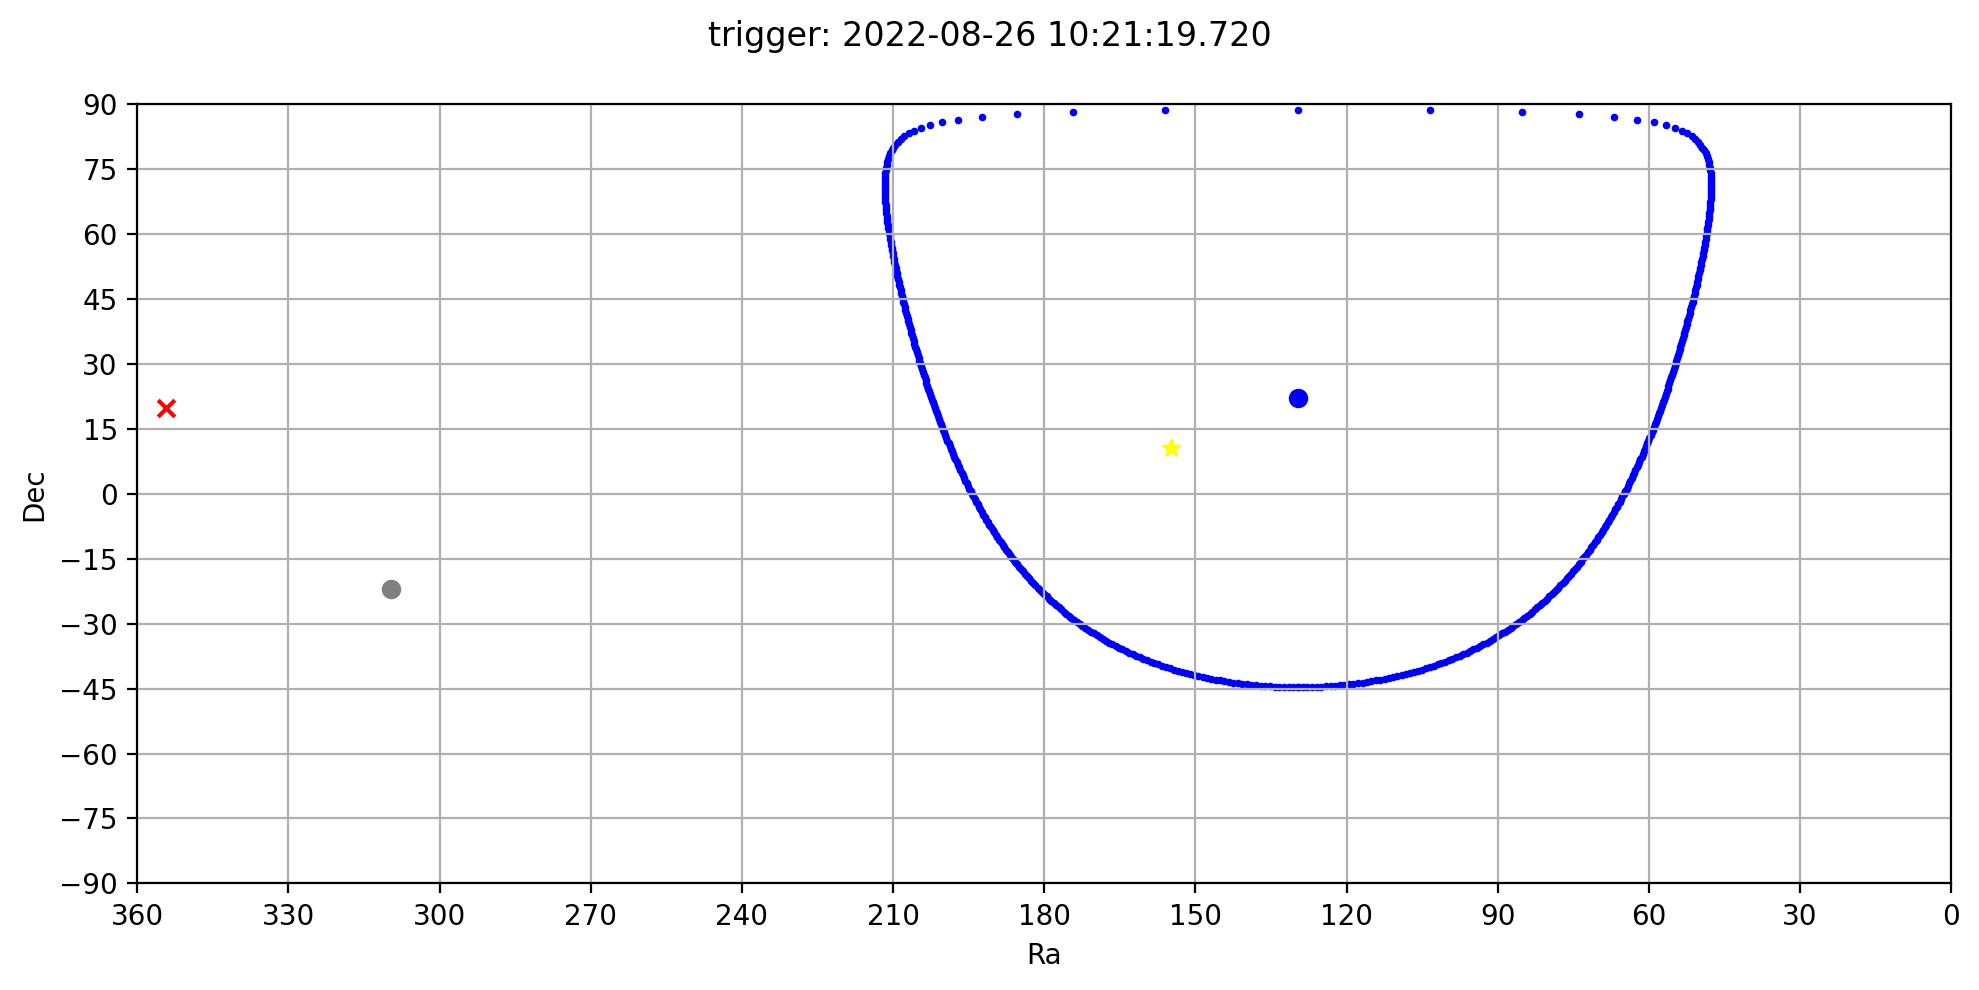

In [95]:
fig, ax = plt.subplots(figsize=(10,5),dpi=200)
fig.suptitle(f'trigger: {utc}')
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.yaxis.set_major_locator(ticker.MultipleLocator(15))
ax.set_xlim(360,0)
ax.set_ylim(-90,90)
ax.set_xlabel('Ra')
ax.set_ylabel('Dec')
ax.grid(True)
fig.tight_layout()

# ax.scatter(ra_sat,dec_sat,c='grey')
# ax.scatter(ra_grb,dec_grb,marker='x',c='red')
ax.scatter(ra_sun,dec_sun,marker='*',c='yellow')

ax.scatter(ra_nadir,dec_nadir,c='b')
ax.scatter(Earth_ra,Earth_dec,c='b',s=3)    


In [14]:
df = pd.read_csv(r'C:\Users\maria\Desktop\CubeSats\all_grbalpha_data.csv')
lon = df.longitude
lat = df.latitude
alt = df.altitude
cps1 = df.cps_64_128
cps2 = df.cps_128_192
cps3 = df.cps_192_256
time = pd.to_datetime(df.time)
sun_fov = df.sun_in_fov
direction = df.direction

In [15]:
# get list of indices where sun crosses the horizon
sunrise, sunset = [], []
for i in range(len(df)-1):
    if np.logical_and(np.logical_and(sun_fov[i] == True, sun_fov[i+1] == False), time[i+1] - time[i] < pd.Timedelta('30min')):
        # equatorial region
        if np.logical_and(np.logical_or(lon[i] < 50, lon[i] > 275),
                          np.logical_and(lat[i] > 0, lat[i] < 40)):
            sunset.append((i,i+1))
        elif np.logical_and(np.logical_and(lon[i] >= 50, lon[i] <= 275),
                            np.logical_and(lat[i] > -30, lat[i] < 40)):
            sunset.append((i,i+1))
    elif np.logical_and(np.logical_and(sun_fov[i] == False, sun_fov[i+1] == True), time[i+1] - time[i] < pd.Timedelta('30min')):
        # equatorial region
        if np.logical_and(np.logical_or(lon[i] < 50, lon[i] > 275),
                          np.logical_and(lat[i] > 0, lat[i] < 40)):
            sunrise.append((i,i+1))
        elif np.logical_and(np.logical_and(lon[i] >= 50, lon[i] <= 275),
                            np.logical_and(lat[i] > -30, lat[i] < 40)):
            sunrise.append((i,i+1))


In [16]:
len(sunrise),len(sunset)

(403, 398)

In [27]:
sunrise[3]

(8724, 8725)

In [49]:
i-delta

328

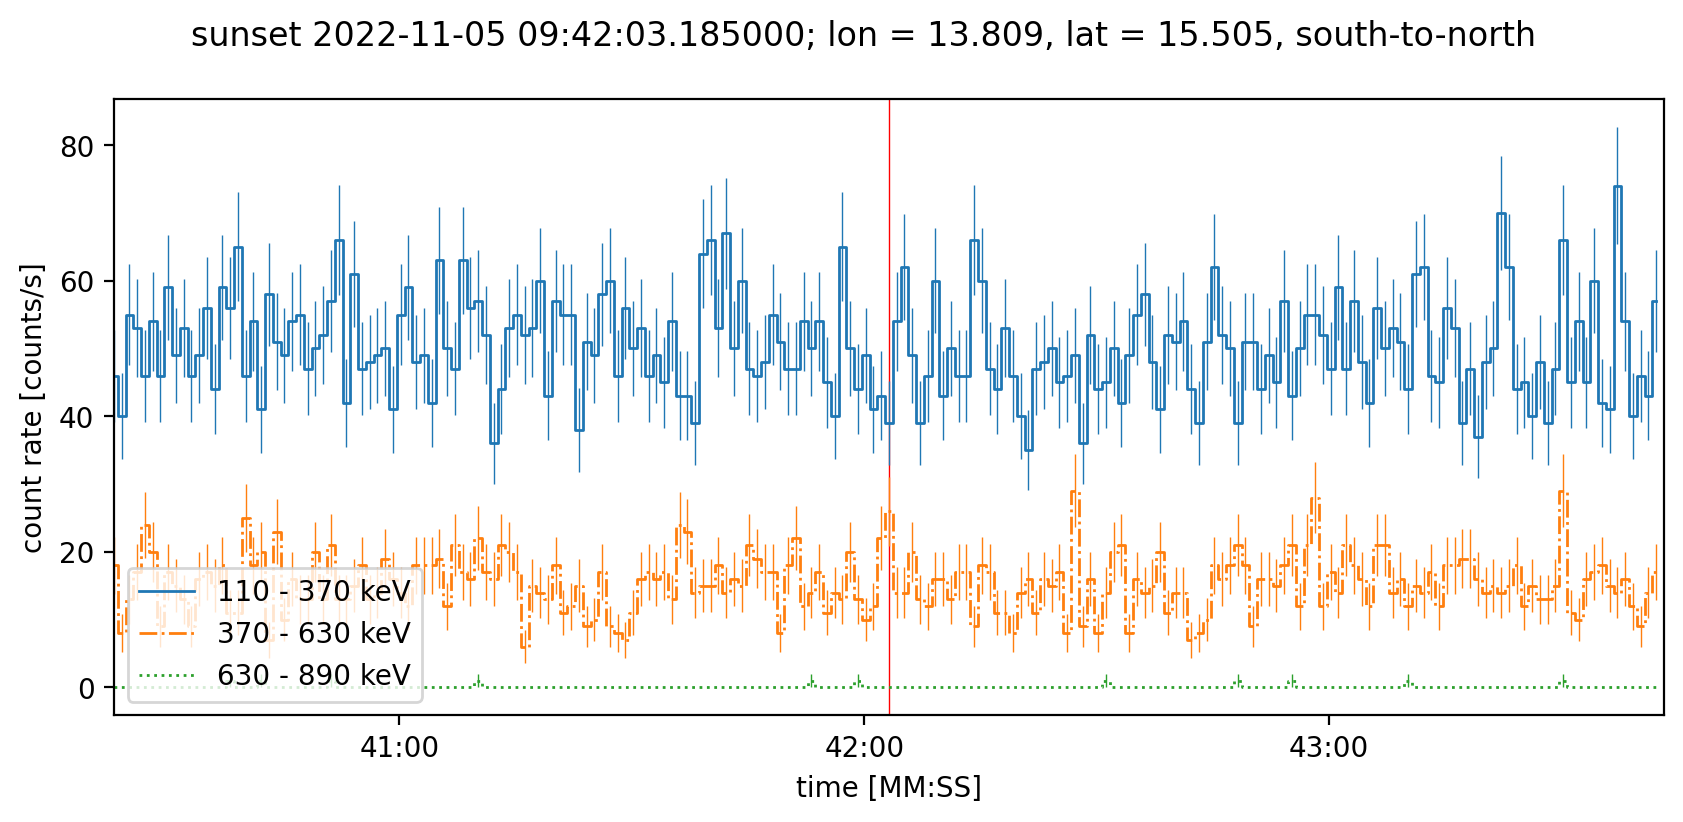

In [55]:
i = sunset[306][0] # 290-320?
delta = 100

# plot
fig, ax = plt.subplots(figsize=(10,4),dpi=200)
fig.suptitle(f'sunset {time[i]}; lon = {lon[i]}, lat = {lat[i]}, {direction[i]}')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))#byminute=[40,50,0,10]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
plt.axvline(time[i],c='r',lw=0.5)

plt.step(time[i-delta:i+delta],cps1[i-delta:i+delta],c='C0',where='mid',lw=1,label='110 - 370 keV')
plt.errorbar(time[i-delta:i+delta],cps1[i-delta:i+delta],yerr=np.sqrt(cps1[i-delta:i+delta]),c='C0',lw=0.5,fmt=' ')
plt.step(time[i-delta:i+delta],cps2[i-delta:i+delta],'-.',c='C1',where='mid',lw=1,label='370 - 630 keV')
plt.errorbar(time[i-delta:i+delta],cps2[i-delta:i+delta],yerr=np.sqrt(cps2[i-delta:i+delta]),c='C1',lw=0.5,fmt=' ')
plt.step(time[i-delta:i+delta],cps3[i-delta:i+delta],':',c='C2',where='mid',lw=1,label='630 - 890 keV')
plt.errorbar(time[i-delta:i+delta],cps3[i-delta:i+delta],yerr=np.sqrt(cps3[i-delta:i+delta]),c='C2',lw=0.5,fmt=' ')
    
plt.xlim(time[i-delta],time[i+delta])
plt.xlabel('time [MM:SS]')
plt.ylabel('count rate [counts/s]')
plt.legend(loc='lower left')
plt.show()


In [57]:
ss = []
for i in sunset:
    ss.append(direction[i[0]])

sr = []
for i in sunrise:
    sr.append(direction[i[0]])
    

In [68]:
sum(np.asarray(sr) == 'south-to-north'), sum(np.asarray(sr) == 'north-to-south')

(397, 6)